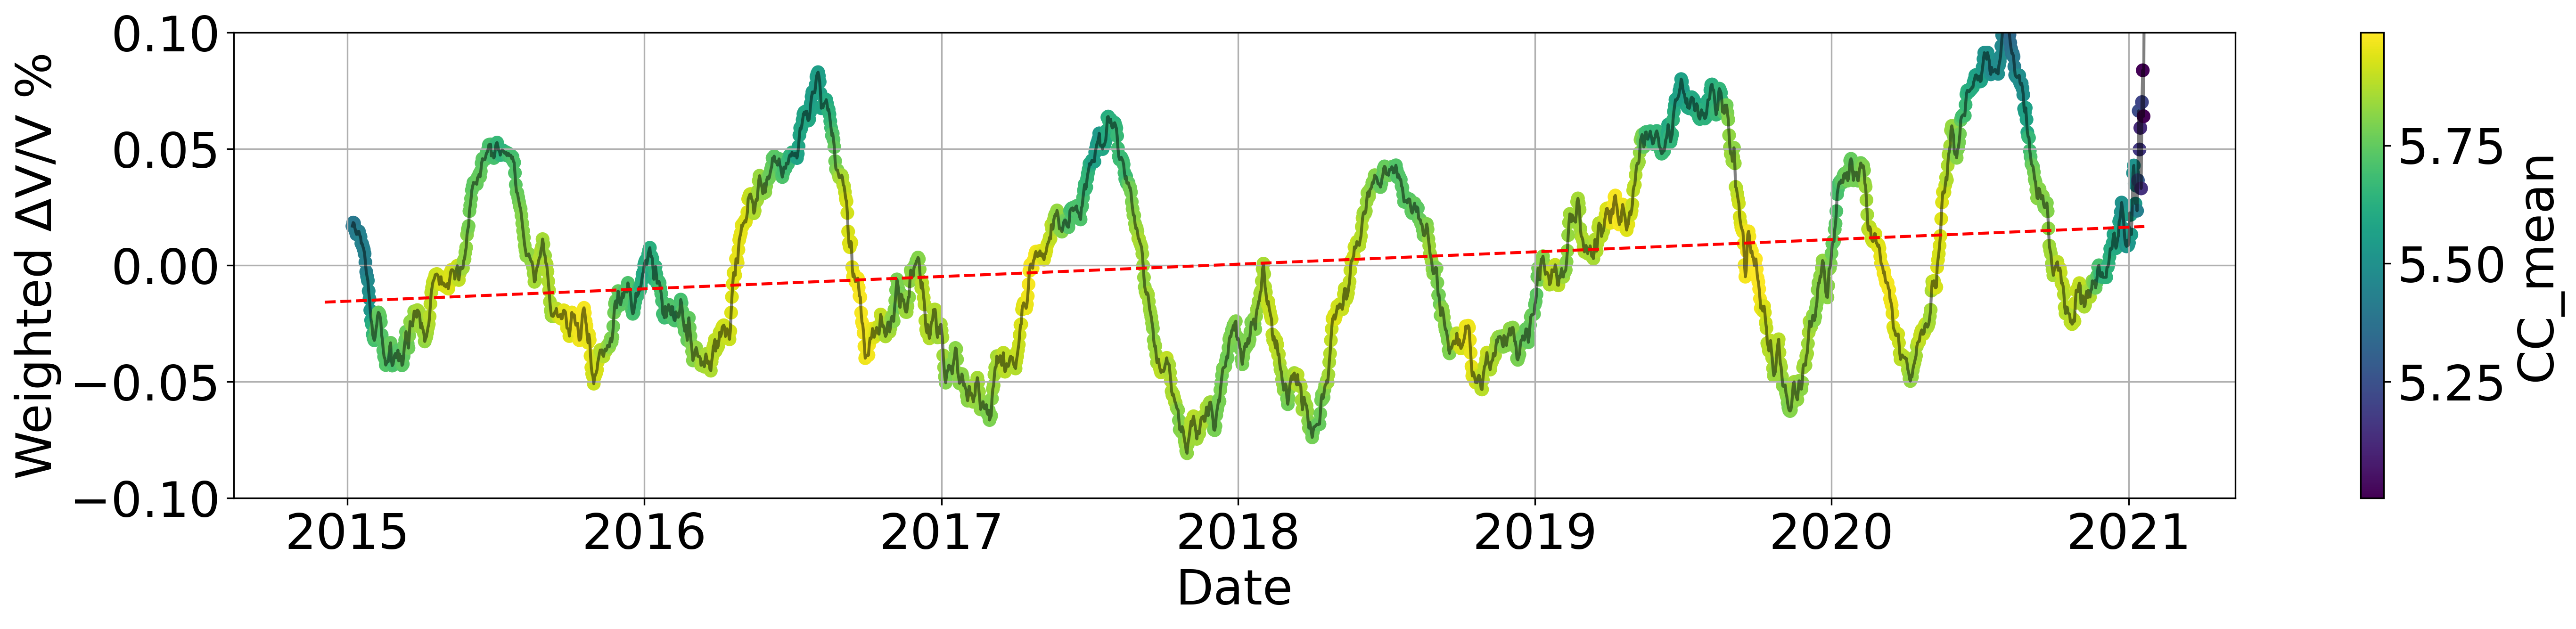

In [41]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import os


# Define the paths to your CSV files
file_paths = [
    'B1_60daystack_0p1to0p3 positiveZN 1060svd7x.csv',
    'B1_60daystack_0p1to0p3 negativeZN 6010svd7x.csv',
    'B1_60daystack_0p1to0p3 positiveNE 1060svd7x.csv',
    'B1_60daystack_0p1to0p3 negativeNE 6010svd7x.csv',
    'B1_60daystack_0p1to0p3 positiveZE 1060svd7x.csv',
    'B1_60daystack_0p1to0p3 negativeZE 6010svd7x.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1,1, 1, 1, 1, 1]

dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    
    

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Define the date range to exclude
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2024-01-30")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2010-01-10")
end_date = pd.to_datetime("2011-02-05")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(20, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')
# Adding a trend line

#plt.title('Weighted Δv/v For HYS14 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.1,0.1])
plt.ylabel('Weighted ΔV/V %')
plt.grid(True)

cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])

# Convert index to int64
index_as_int = cleaned_df.index.astype(np.int64)

# Perform the polynomial fit
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)

plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
start_date = pd.to_datetime("2010-07-01")
end_date = pd.to_datetime("2024-03-01")
plt.rcParams.update({'font.size': 25})
#plt.xlim([start_date, end_date])
plt.xticks()
plt.tight_layout()
plt.show()

Sampling rate: 1.0 samples per day


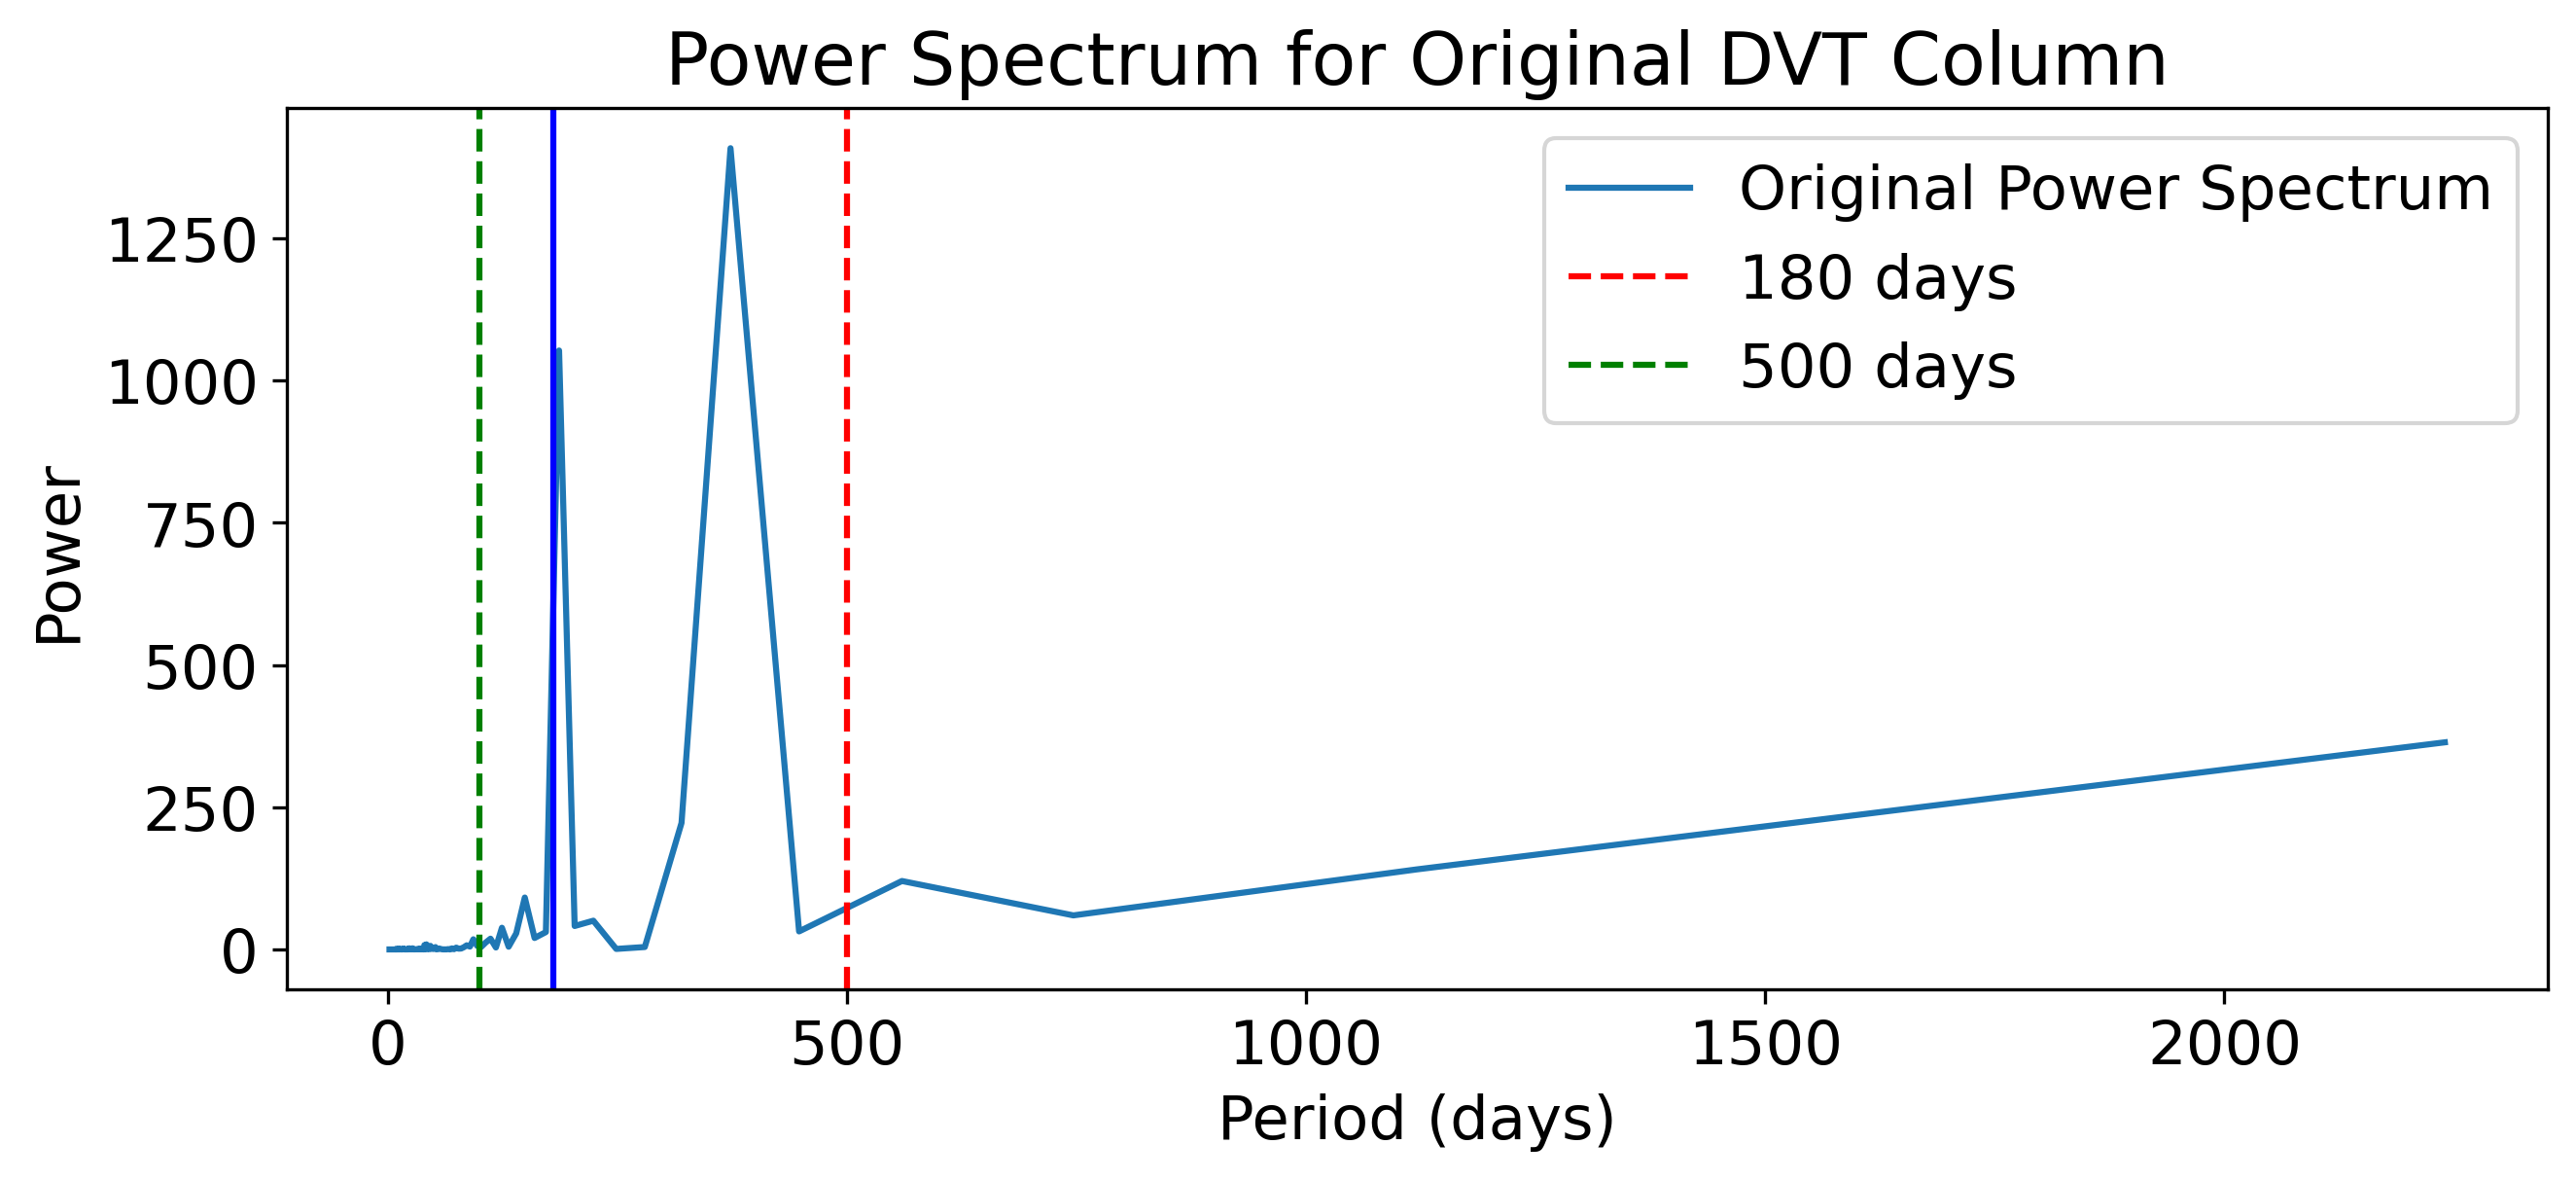

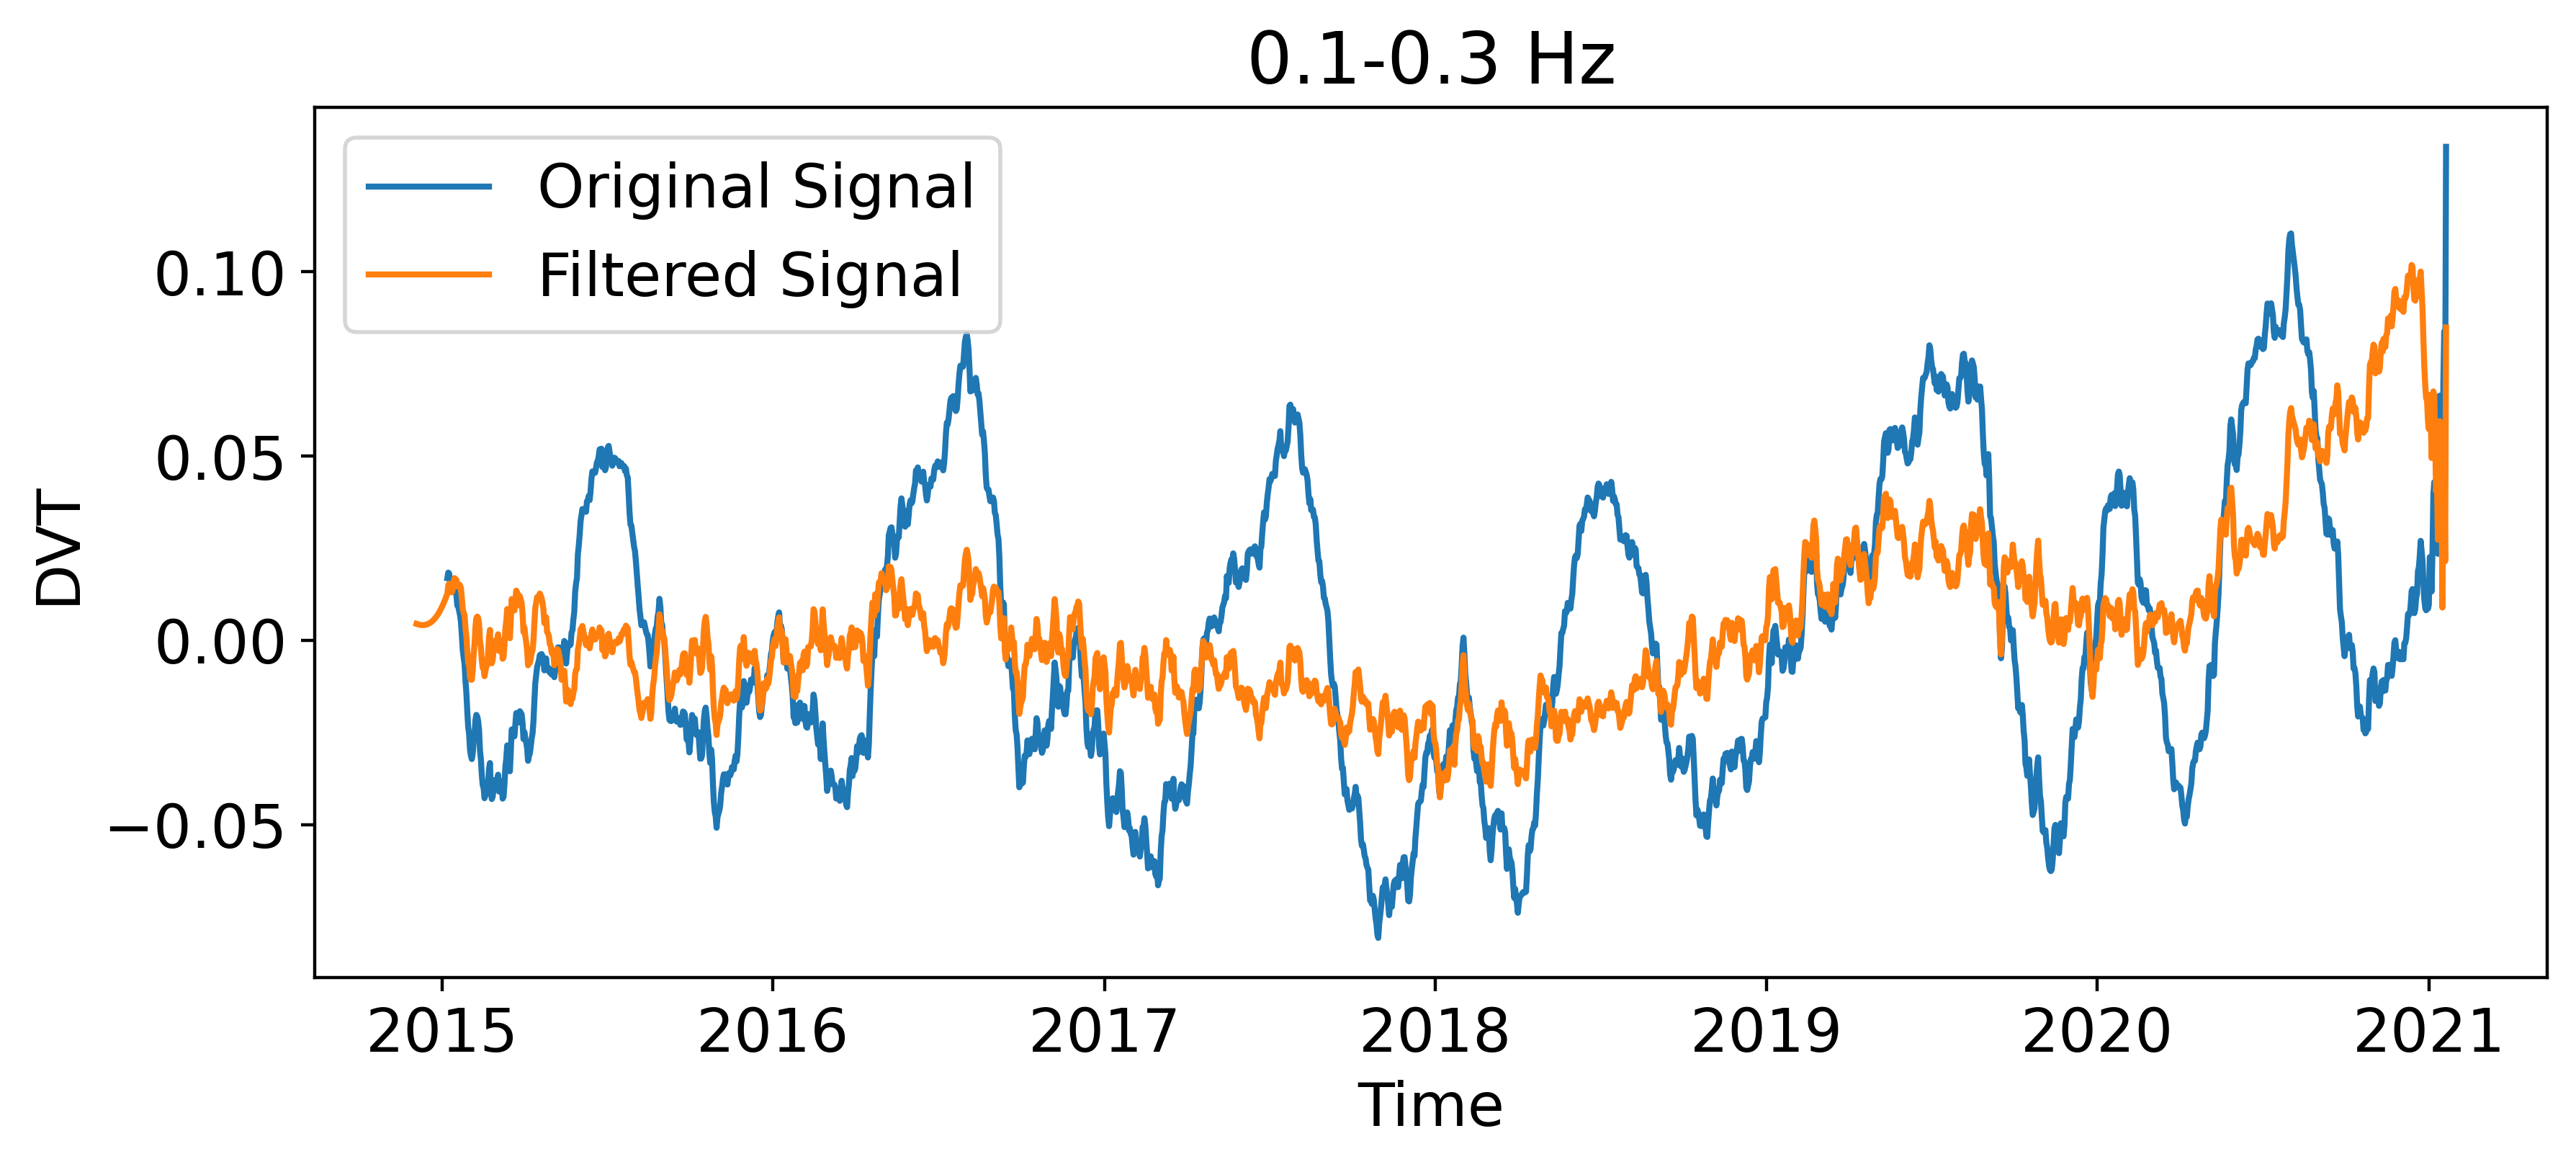

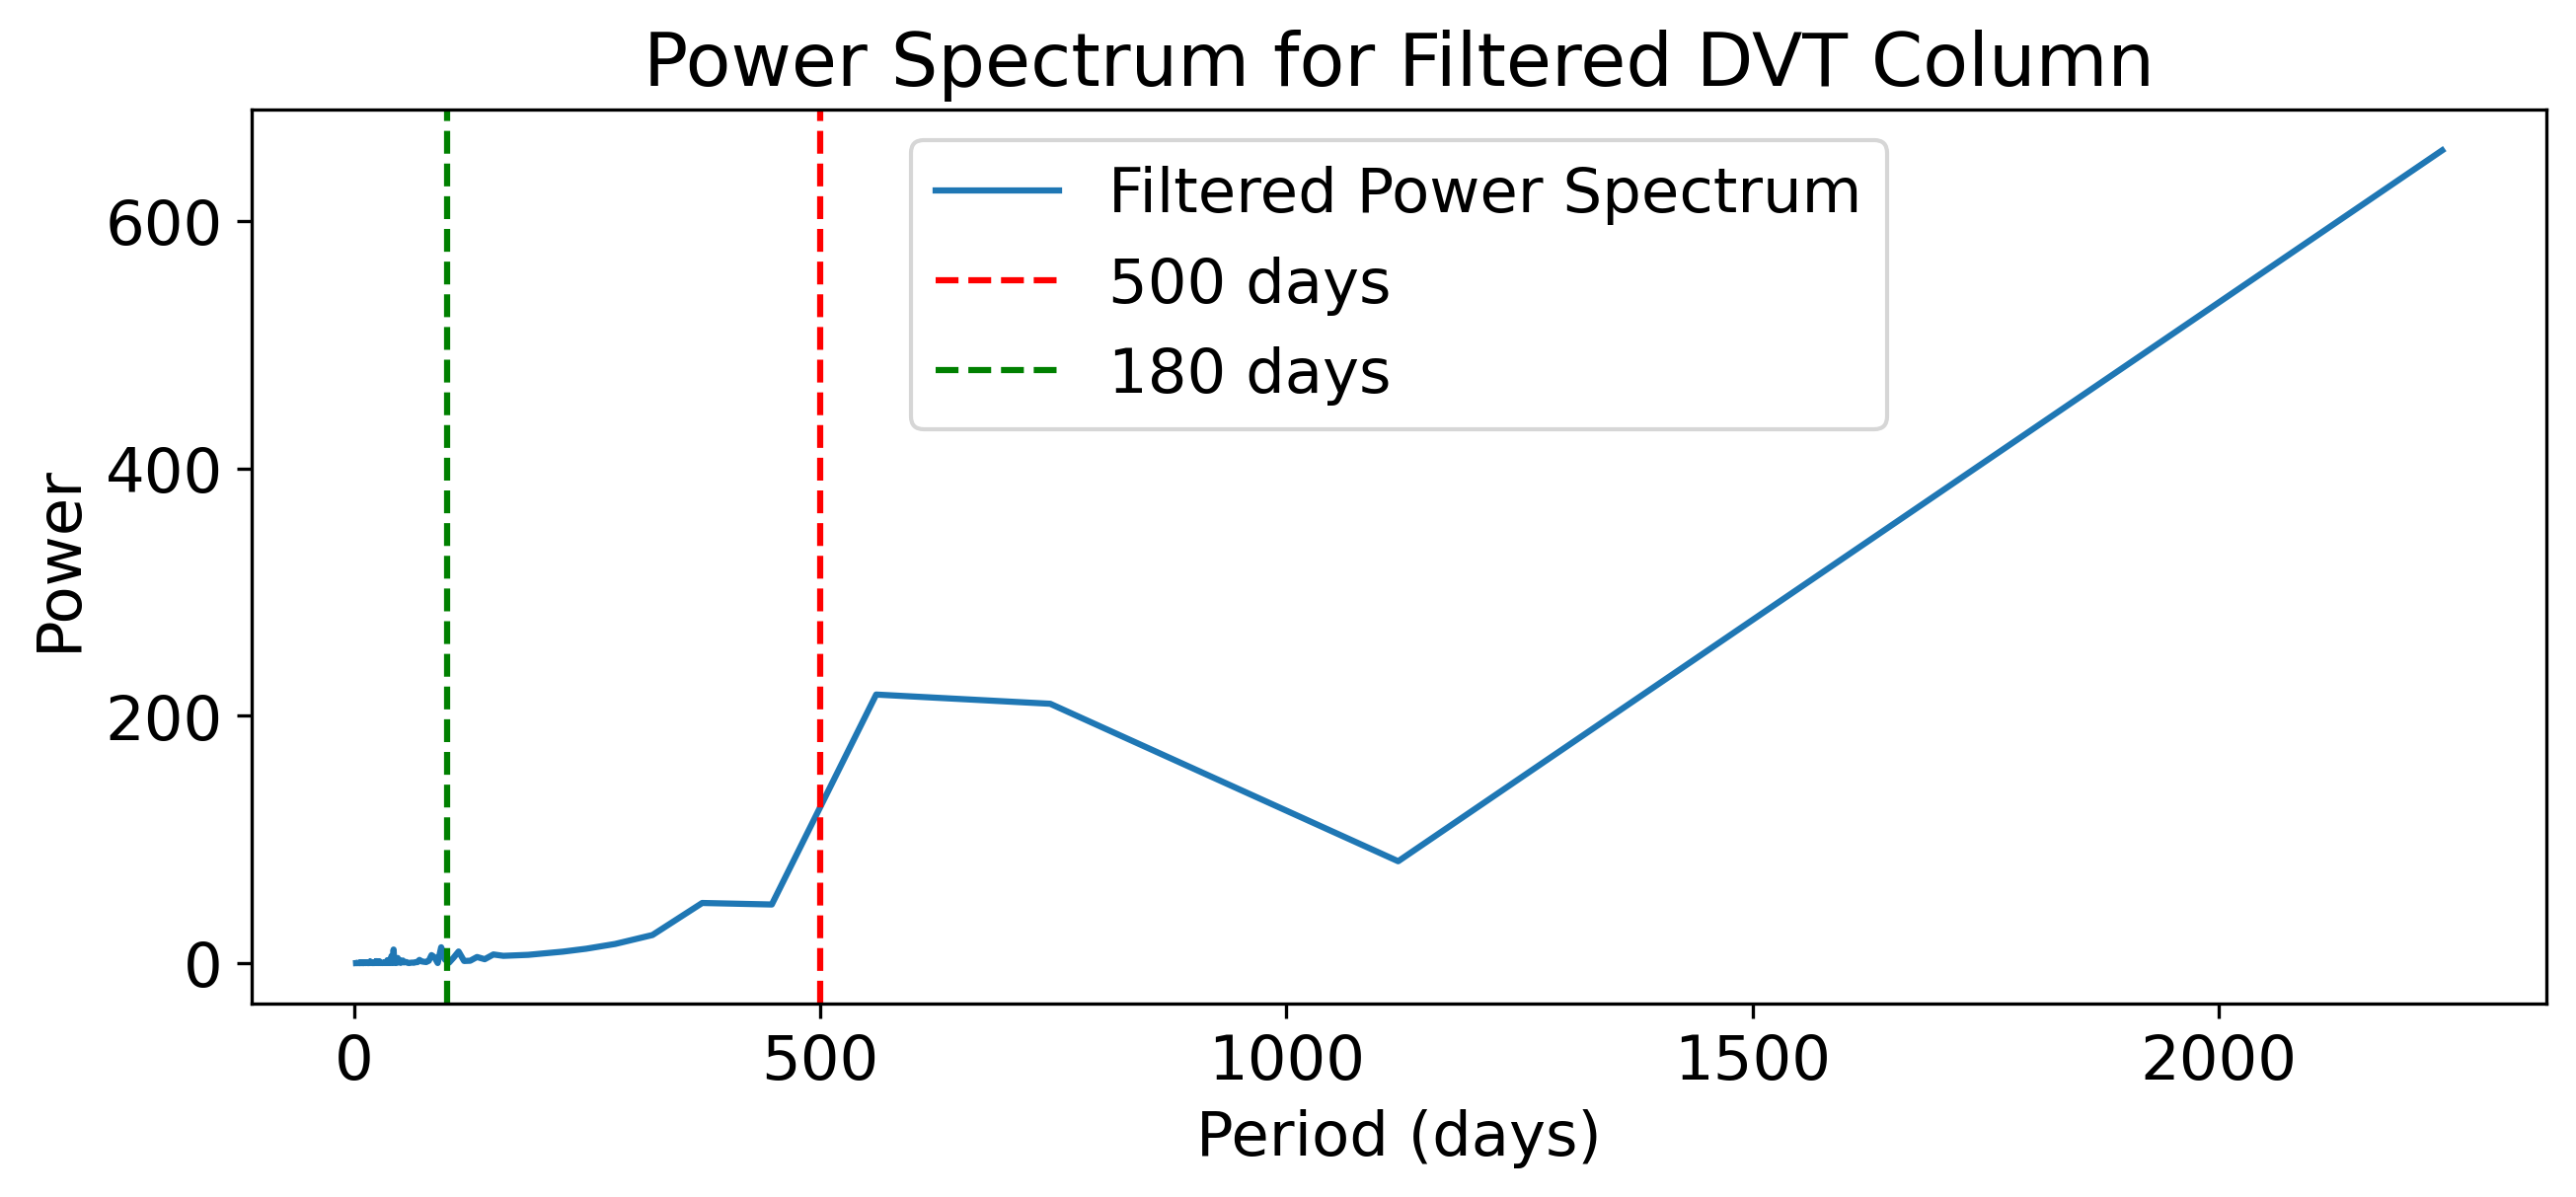

In [43]:
# Assuming weighted_dvv_df is already defined and has a DatetimeIndex
index = weighted_dvv_df.index

# Calculate the time differences between consecutive dates
time_diffs = np.diff(index).astype('timedelta64[D]')

# Calculate the mean time difference in days
mean_time_diff = np.mean(time_diffs).astype('timedelta64[D]').astype(float)

# Calculate the sampling rate as the reciprocal of the mean time difference
samplingrate = 1 / mean_time_diff

print(f"Sampling rate: {samplingrate} samples per day")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Assuming weighted_dvv_df is already defined
# weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Extract the 'Weighted Δv/v' column into a separate variable
dvt_values = weighted_dvv_df['Weighted Δv/v'].values

# Interpolate or fill NaNs in the signal
dvt_values_filled = pd.Series(dvt_values).interpolate().fillna(method='bfill').fillna(method='ffill').values

# Define the sample rate
samplingrate = 1  # Sample rate is 1 sample per day
fs = 1 / samplingrate

# Define the stop band
lowcut = 1 / 500  # 1/500 days
highcut = 1 / 100  # 1/180 days

# Design the band-stop filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(2, [low, high], btype='bandstop')

# Apply the band-stop filter to the signal
filtered_dvt_values = filtfilt(b, a, dvt_values_filled)

# Perform FFT on the original signal
n = len(dvt_values_filled)
dvt_fft = fft(dvt_values_filled)
frequencies = fftfreq(n, d=1/fs)
power_spectrum = np.abs(dvt_fft)**2

# Perform FFT on the filtered signal
filtered_dvt_fft = fft(filtered_dvt_values)
filtered_power_spectrum = np.abs(filtered_dvt_fft)**2

# Get the positive frequencies and power spectrum
positive_frequencies = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]
filtered_positive_power_spectrum = filtered_power_spectrum[frequencies > 0]

plt.rcParams.update({'font.size': 15})
# Plot the power spectrum of the original signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, positive_power_spectrum, label='Original Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--', label='180 days')
plt.axvline(x=1/highcut, color='g', linestyle='--', label='500 days')
plt.axvline(x=180,color='b')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Original DVT Column')
plt.legend()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4), dpi=400)
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('DVT')
plt.title('0.1-0.3 Hz')
plt.legend()
plt.show()

# Plot the power spectrum of the filtered signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, filtered_positive_power_spectrum, label='Filtered Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--', label='500 days')
plt.axvline(x=1/highcut, color='g', linestyle='--', label='180 days')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Filtered DVT Column')
plt.legend()
plt.show()


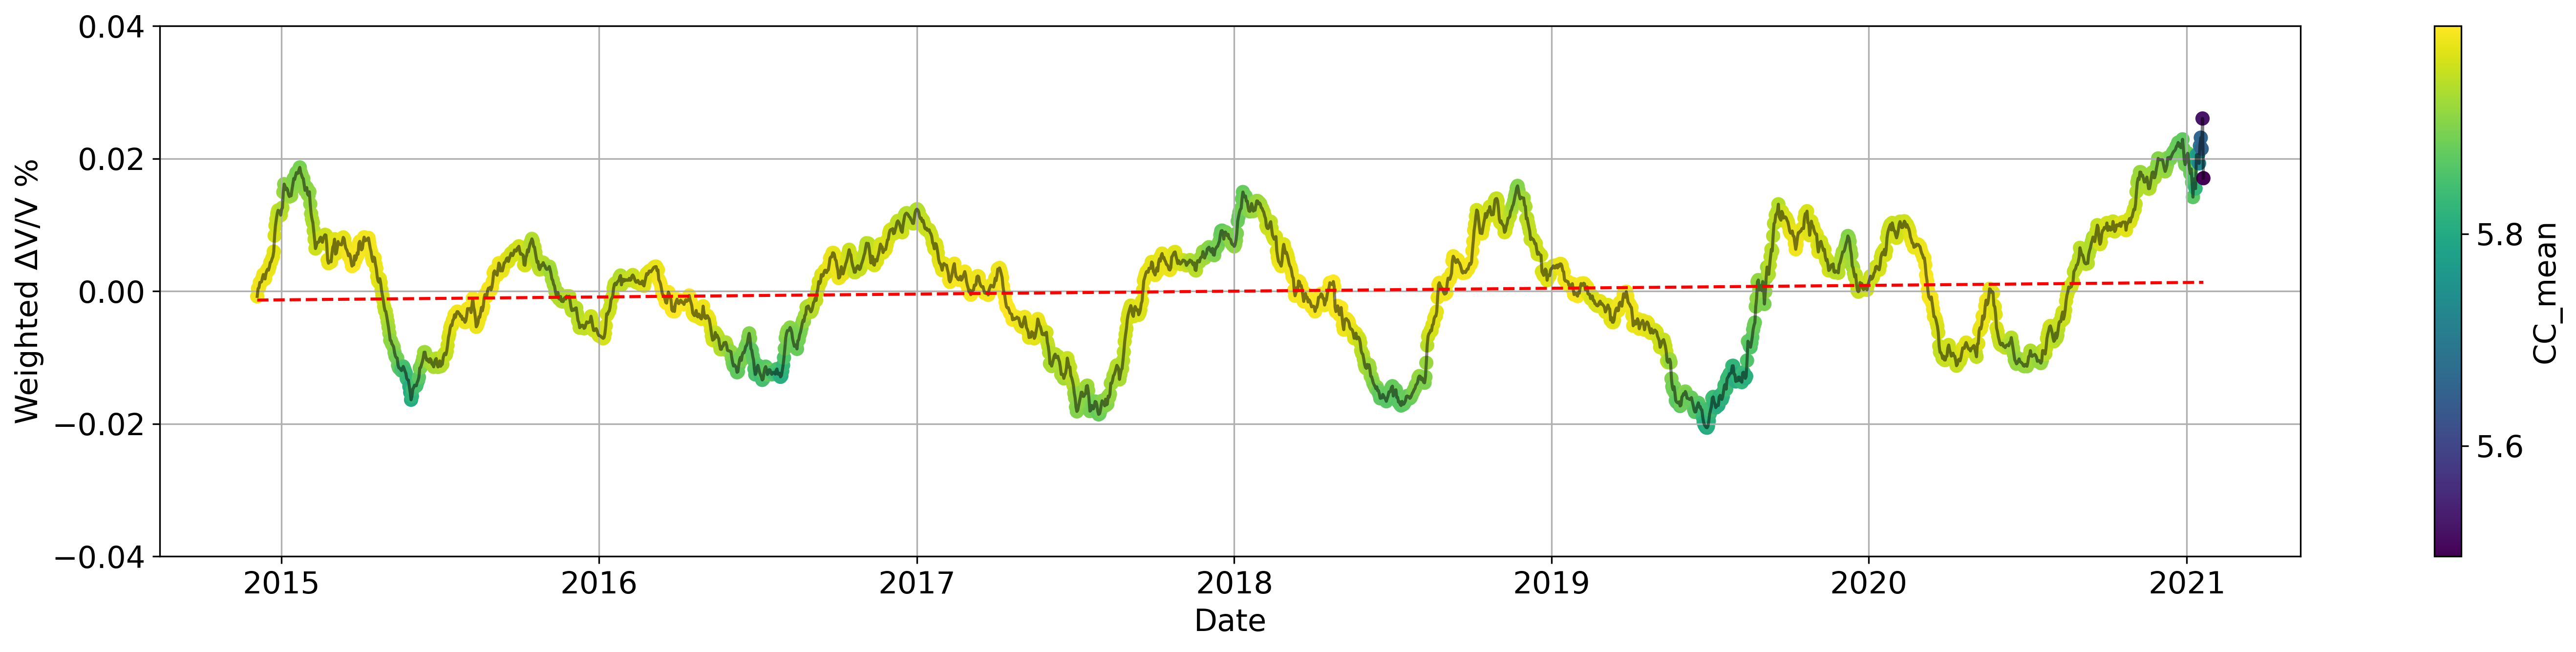

In [18]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import os


# Define the paths to your CSV files
file_paths = [
    'B1_60daystack_0p3to0p6 positiveZN 1560svd7x.csv',
    'B1_60daystack_0p3to0p6 negativeZN 6015svd7x.csv',
    'B1_60daystack_0p3to0p6 positiveNE 1560svd7x.csv',
    'B1_60daystack_0p3to0p6 negativeNE 6015svd7x.csv',
    'B1_60daystack_0p3to0p6 positiveZE 1560svd7x.csv',
    'B1_60daystack_0p3to0p6 negativeZE 6015svd7x.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1,1, 1, 1, 1, 1]

dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    
    

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Define the date range to exclude
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2024-01-30")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2010-01-10")
end_date = pd.to_datetime("2011-02-05")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(20, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')
# Adding a trend line

#plt.title('Weighted Δv/v For HYS14 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.04,0.04])
plt.ylabel('Weighted ΔV/V %')
plt.grid(True)

cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])

# Convert index to int64
index_as_int = cleaned_df.index.astype(np.int64)

# Perform the polynomial fit
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)

plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
start_date = pd.to_datetime("2010-07-01")
end_date = pd.to_datetime("2024-03-01")
plt.rcParams.update({'font.size': 25})
#plt.xlim([start_date, end_date])
plt.xticks()
plt.tight_layout()
plt.show()

Sampling rate: 1.0 samples per day


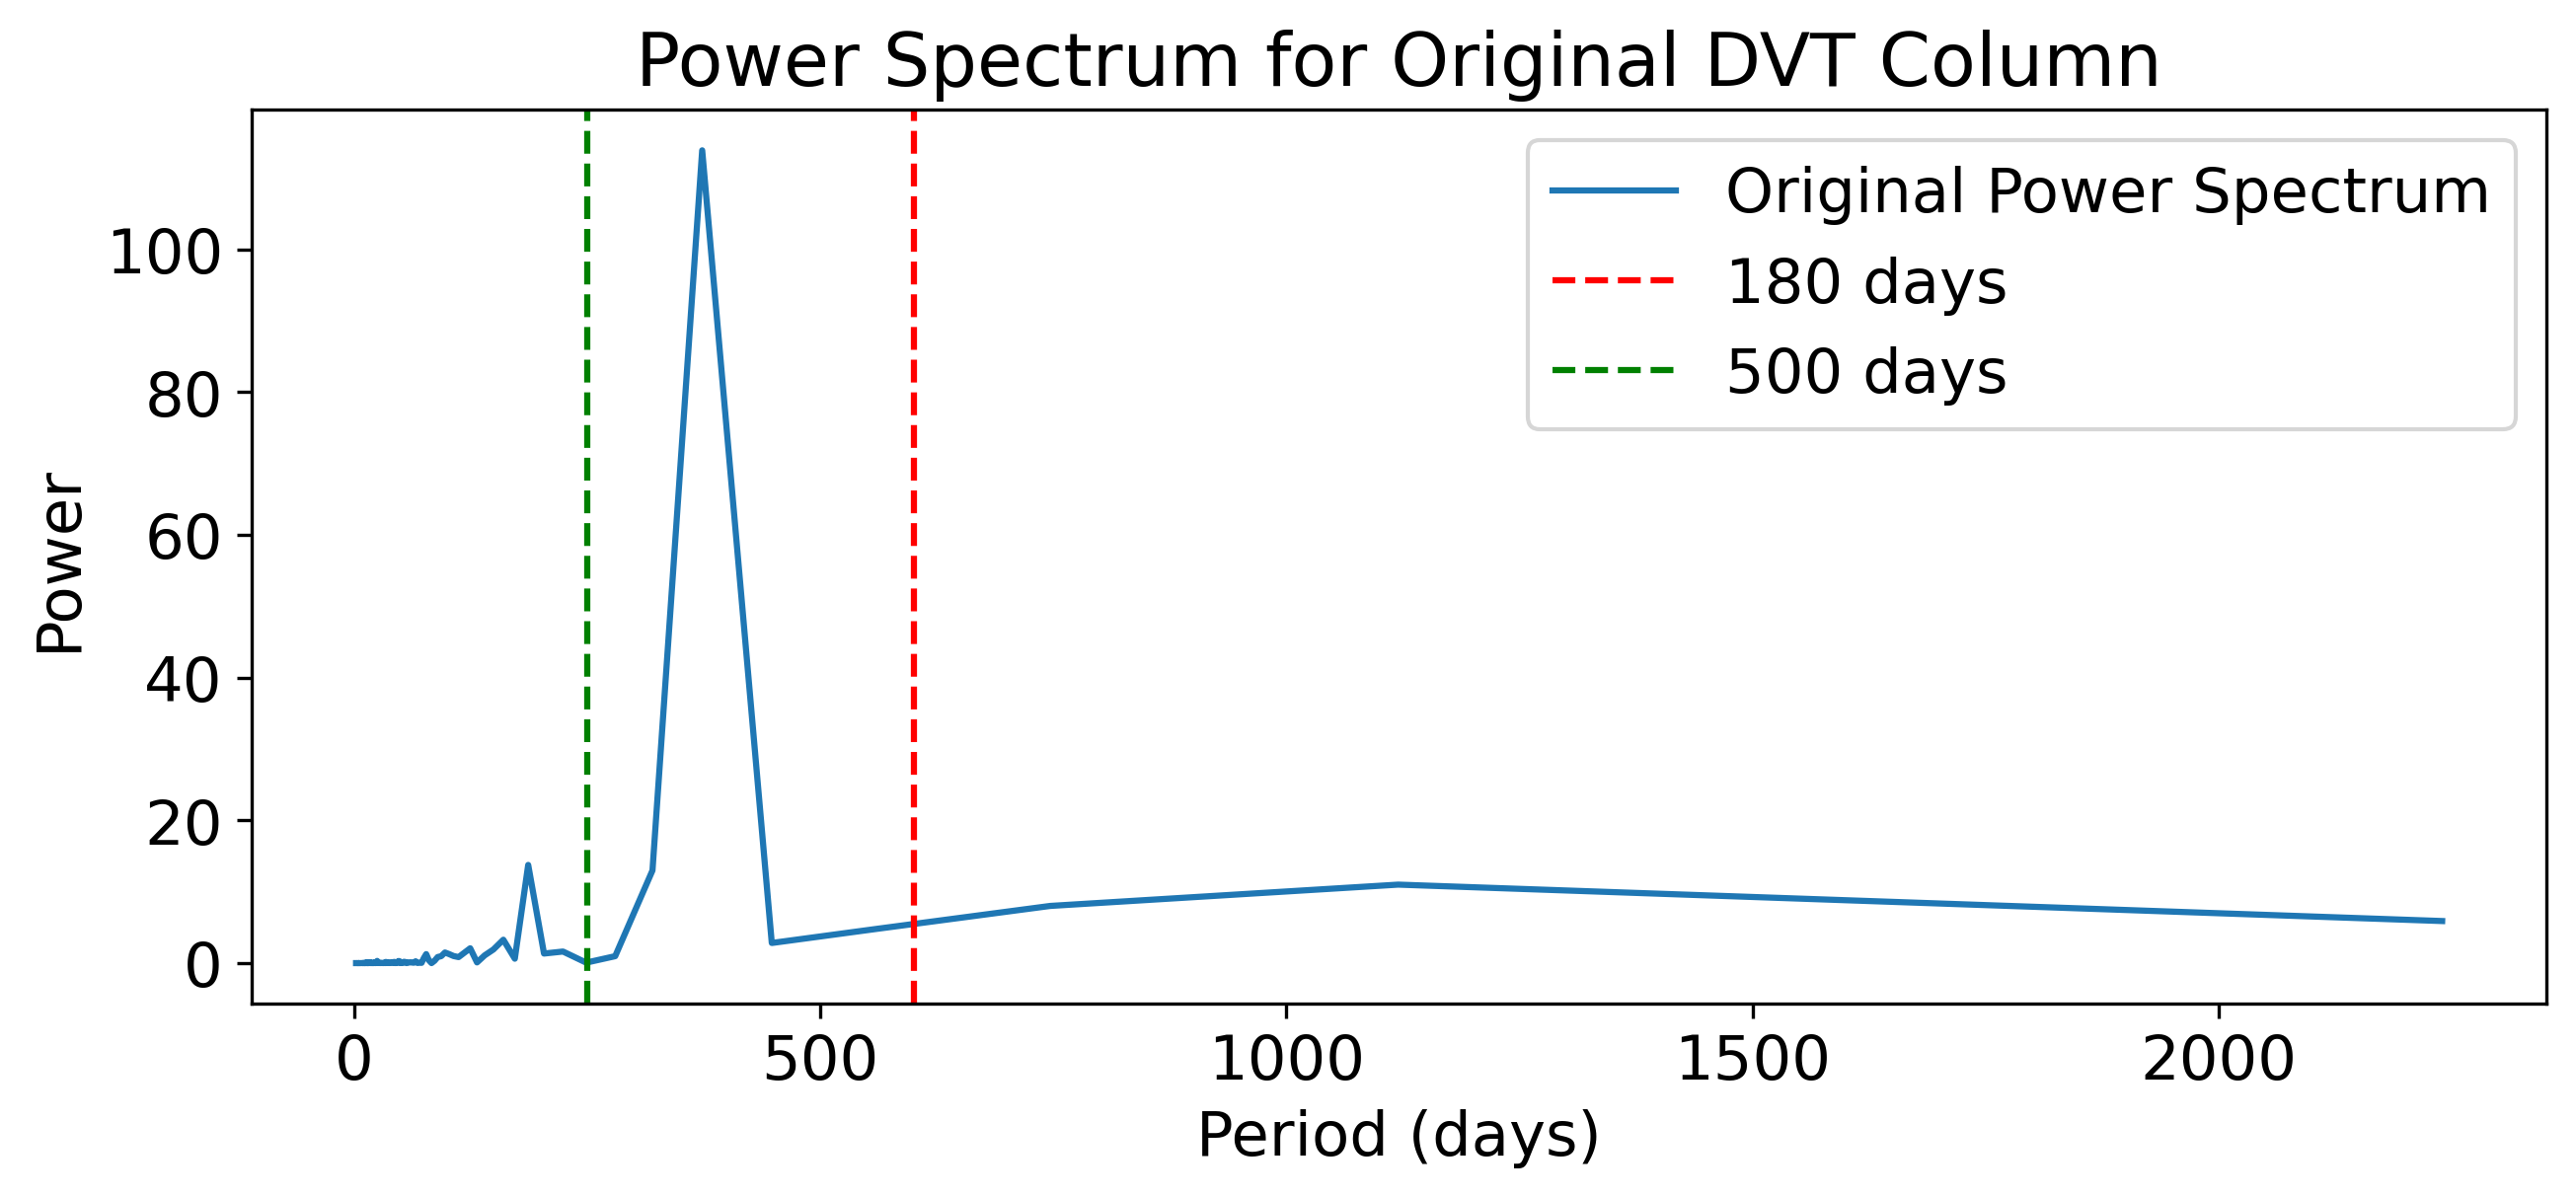

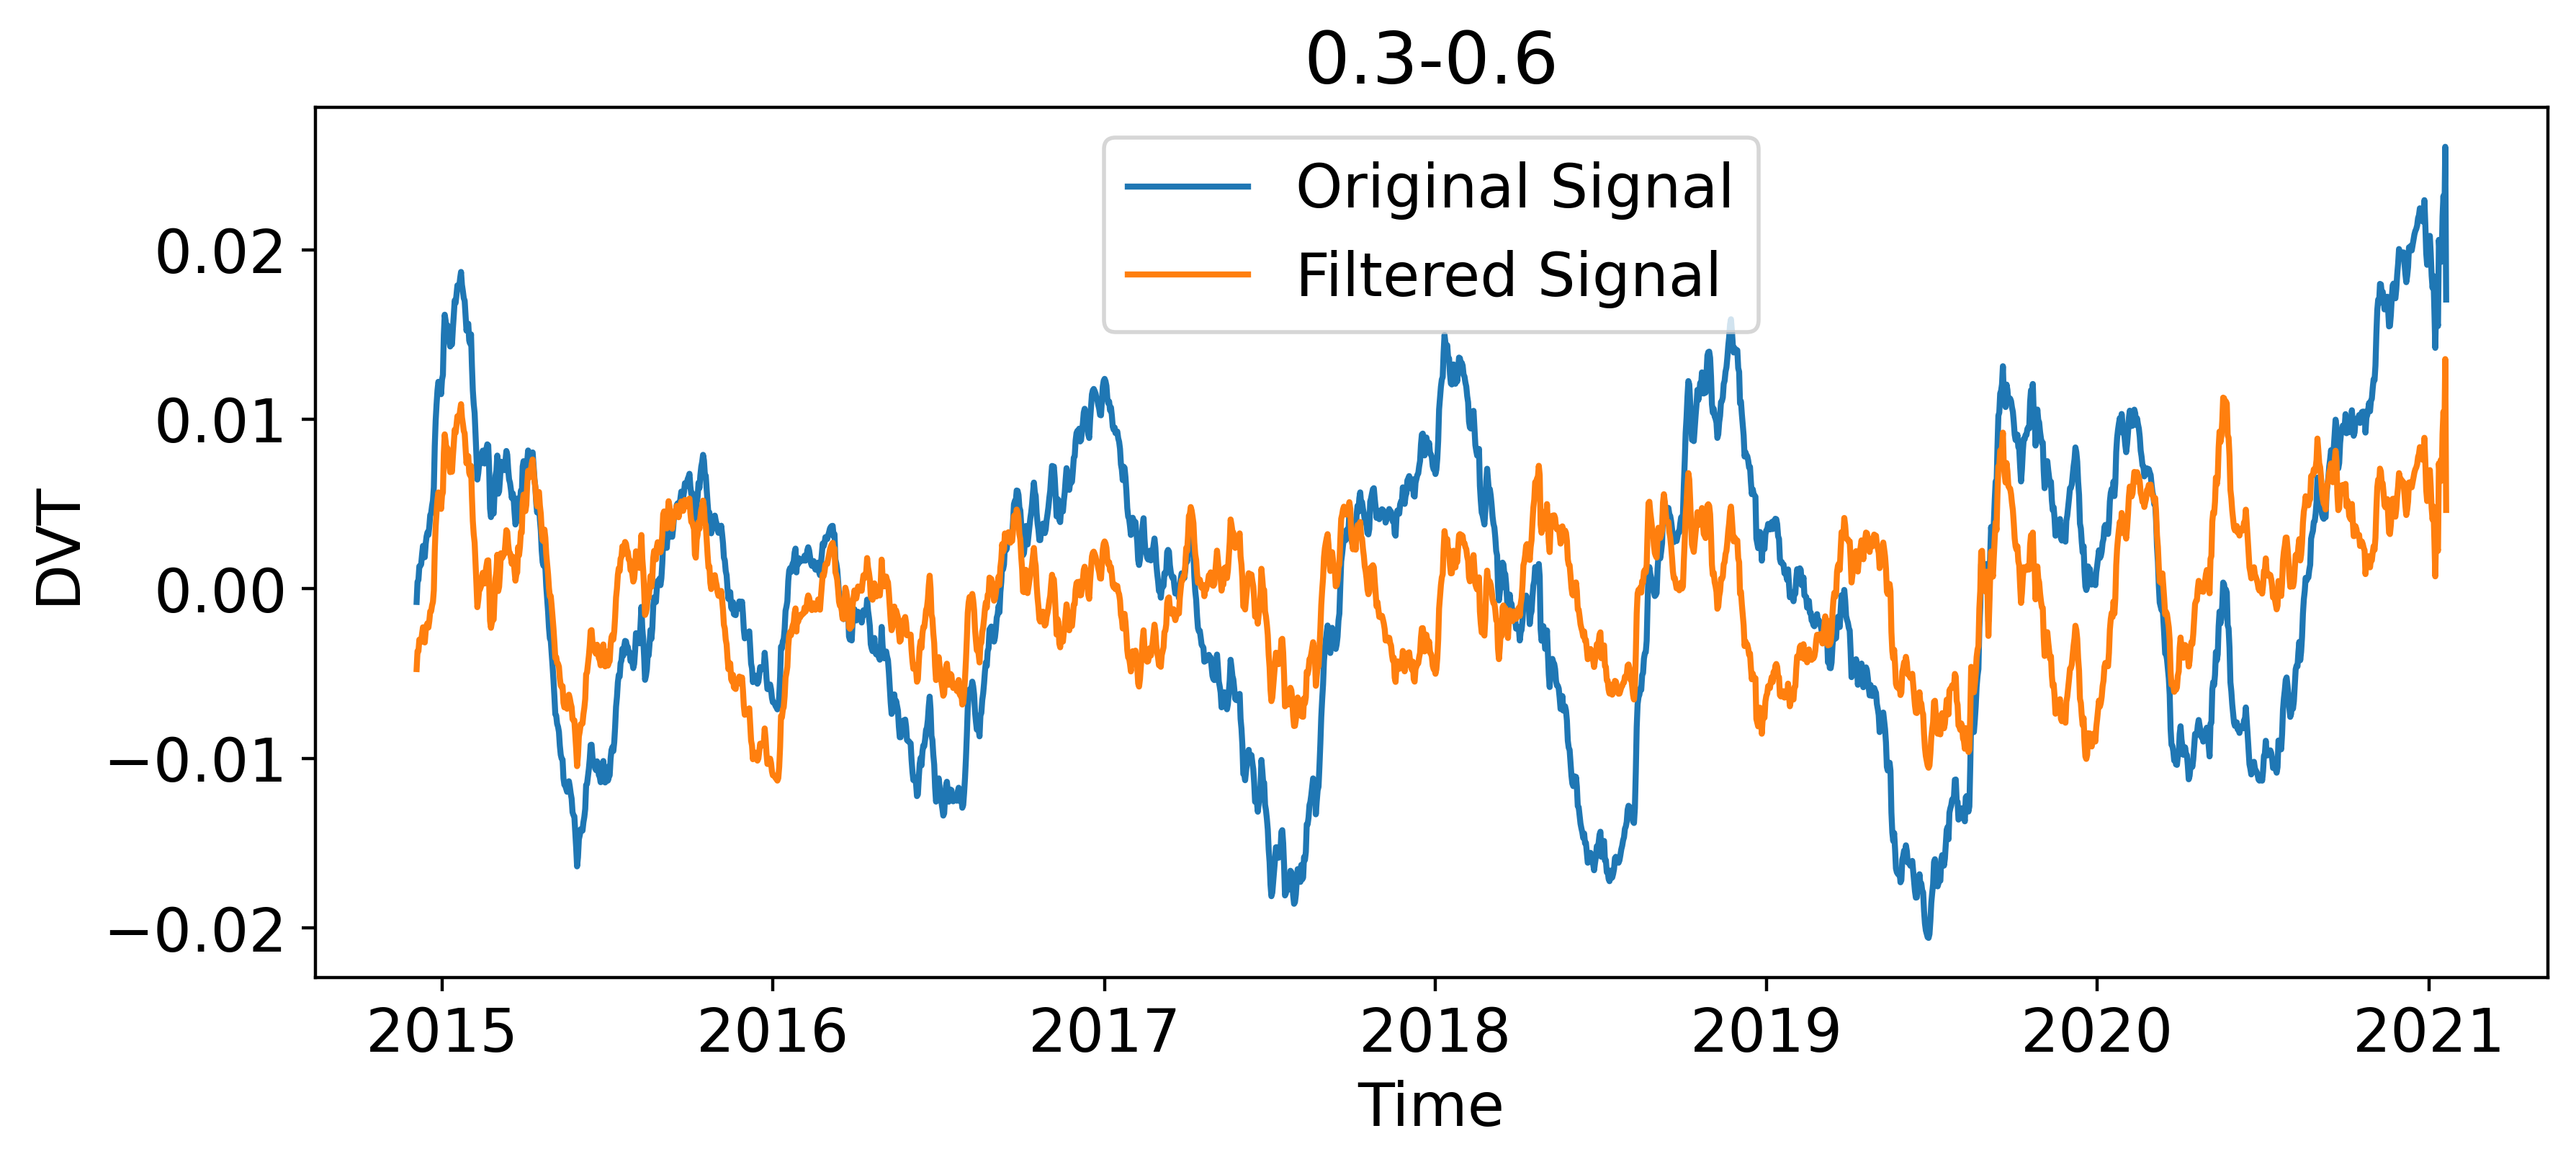

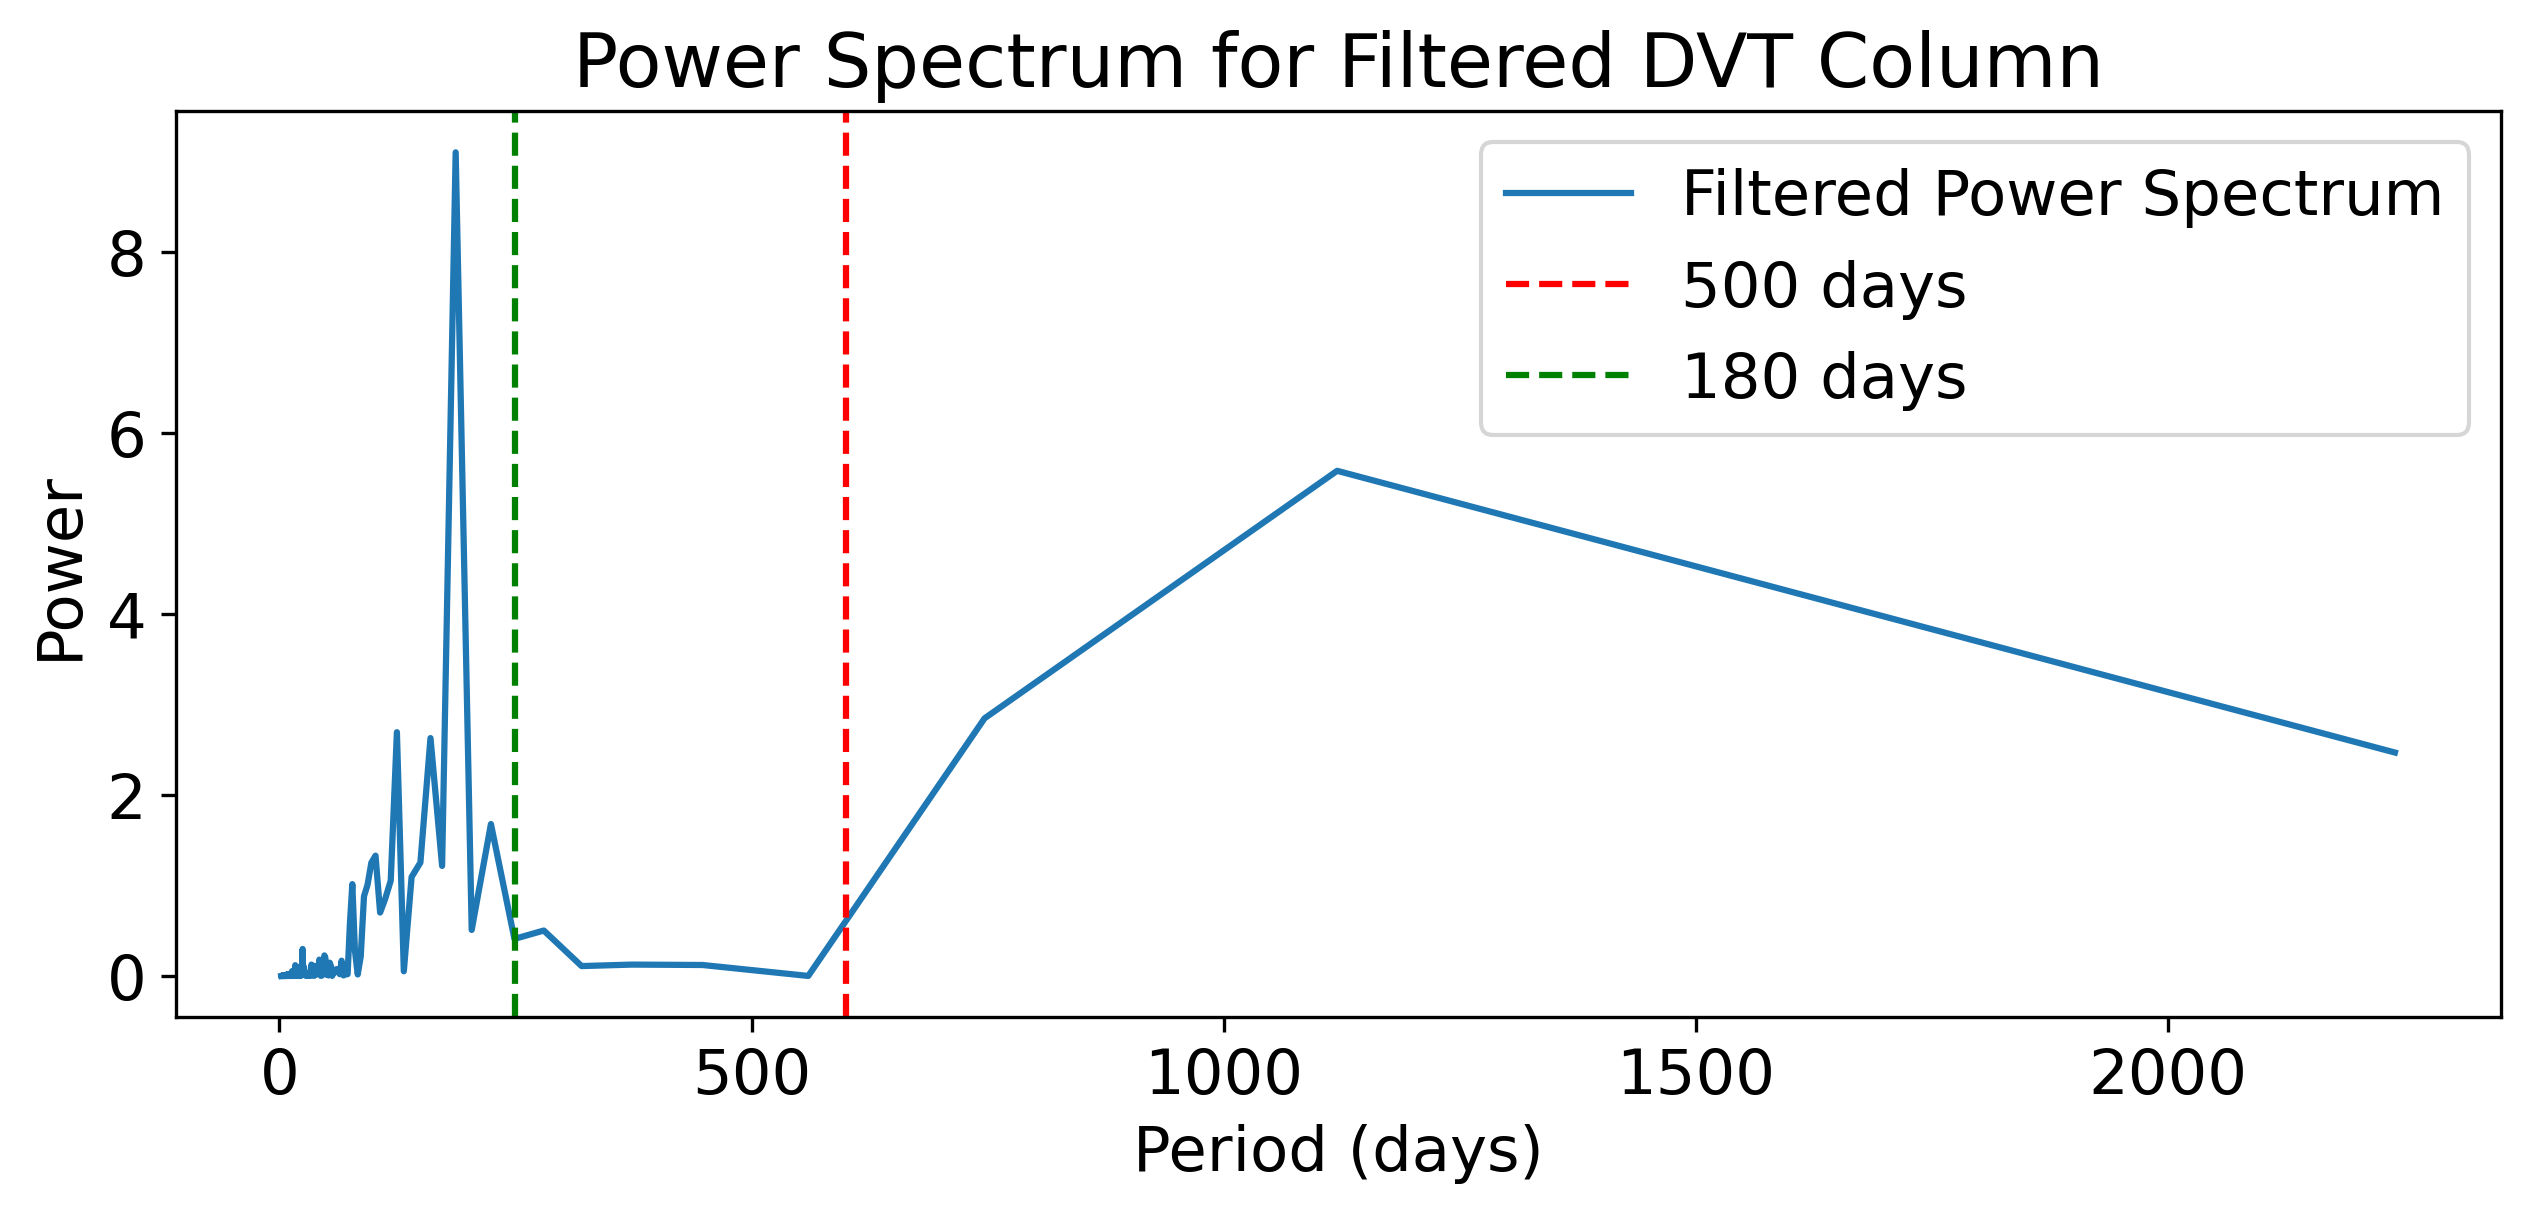

In [21]:
# Assuming weighted_dvv_df is already defined and has a DatetimeIndex
index = weighted_dvv_df.index

# Calculate the time differences between consecutive dates
time_diffs = np.diff(index).astype('timedelta64[D]')

# Calculate the mean time difference in days
mean_time_diff = np.mean(time_diffs).astype('timedelta64[D]').astype(float)

# Calculate the sampling rate as the reciprocal of the mean time difference
samplingrate = 1 / mean_time_diff

print(f"Sampling rate: {samplingrate} samples per day")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Assuming weighted_dvv_df is already defined
# weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Extract the 'Weighted Δv/v' column into a separate variable
dvt_values = weighted_dvv_df['Weighted Δv/v'].values

# Interpolate or fill NaNs in the signal
dvt_values_filled = pd.Series(dvt_values).interpolate().fillna(method='bfill').fillna(method='ffill').values

# Define the sample rate
samplingrate = 1  # Sample rate is 1 sample per day
fs = 1 / samplingrate

# Define the stop band
lowcut = 1 / 600  # 1/500 days
highcut = 1 / 250  # 1/180 days

# Design the band-stop filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(2, [low, high], btype='bandstop')

# Apply the band-stop filter to the signal
filtered_dvt_values = filtfilt(b, a, dvt_values_filled)

# Perform FFT on the original signal
n = len(dvt_values_filled)
dvt_fft = fft(dvt_values_filled)
frequencies = fftfreq(n, d=1/fs)
power_spectrum = np.abs(dvt_fft)**2

# Perform FFT on the filtered signal
filtered_dvt_fft = fft(filtered_dvt_values)
filtered_power_spectrum = np.abs(filtered_dvt_fft)**2

# Get the positive frequencies and power spectrum
positive_frequencies = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]
filtered_positive_power_spectrum = filtered_power_spectrum[frequencies > 0]

plt.rcParams.update({'font.size': 15})
# Plot the power spectrum of the original signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, positive_power_spectrum, label='Original Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--', label='180 days')
plt.axvline(x=1/highcut, color='g', linestyle='--', label='500 days')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Original DVT Column')
plt.legend()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4), dpi=400)
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('DVT')
plt.title('0.3-0.6')
plt.legend()
plt.show()

# Plot the power spectrum of the filtered signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, filtered_positive_power_spectrum, label='Filtered Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--', label='500 days')
plt.axvline(x=1/highcut, color='g', linestyle='--', label='180 days')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Filtered DVT Column')
plt.legend()
plt.show()

#add frequency response curve to the power spectrum plot

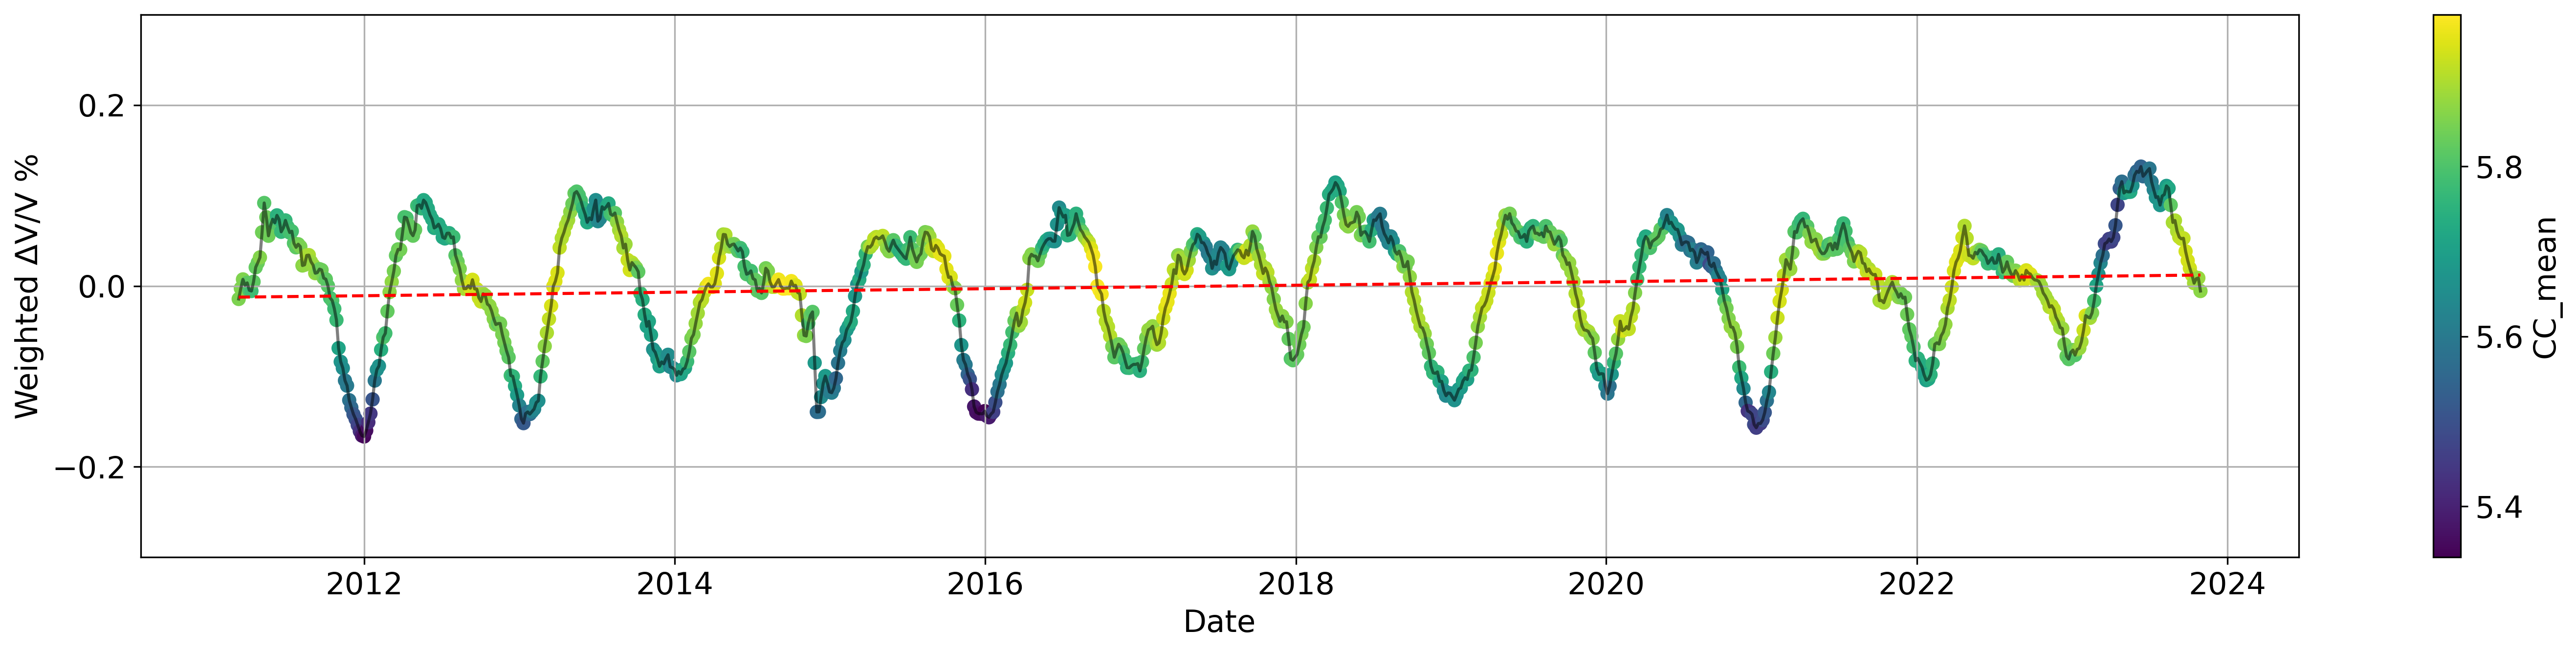

In [37]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import os


# Define the paths to your CSV files
file_paths = [
    '/home/seismic/AmbientNoiseOOI/src/NC89 Results/89_60daystack_0p1to0p3 positiveZN 1060svd7.csv',
    '/home/seismic/AmbientNoiseOOI/src/NC89 Results/89_60daystack_0p1to0p3 negativeZN 6010svd7.csv',
    '/home/seismic/AmbientNoiseOOI/src/NC89 Results/89_60daystack_0p1to0p3 positiveNE 1060svd7.csv',
    '/home/seismic/AmbientNoiseOOI/src/NC89 Results/89_60daystack_0p1to0p3 negativeNE 6010svd7.csv',
    '/home/seismic/AmbientNoiseOOI/src/NC89 Results/89_60daystack_0p1to0p3 positiveZE 1060svd7.csv',
    '/home/seismic/AmbientNoiseOOI/src/NC89 Results/89_60daystack_0p1to0p3 negativeZE 6010svd7.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [-1,1, 1, -1, -1, 1]

dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    
    

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Define the date range to exclude
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2024-01-30")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2010-01-10")
end_date = pd.to_datetime("2011-02-05")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=30)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(20, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')
# Adding a trend line

#plt.title('Weighted Δv/v For HYS14 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.3,0.3])
plt.ylabel('Weighted ΔV/V %')
plt.grid(True)

cleaned_df = weighted_dvv_df.dropna(subset=['Weighted Δv/v'])

# Convert index to int64
index_as_int = cleaned_df.index.astype(np.int64)

# Perform the polynomial fit
z = np.polyfit(index_as_int, cleaned_df['Weighted Δv/v'], 1)
p = np.poly1d(z)

plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
start_date = pd.to_datetime("2010-07-01")
end_date = pd.to_datetime("2024-03-01")
plt.rcParams.update({'font.size': 25})
#plt.xlim([start_date, end_date])
plt.xticks()
plt.tight_layout()
plt.show()

In [1]:
# Assuming weighted_dvv_df is already defined and has a DatetimeIndex
index = weighted_dvv_df.index

# Calculate the time differences between consecutive dates
time_diffs = np.diff(index).astype('timedelta64[D]')

# Calculate the mean time difference in days
mean_time_diff = np.mean(time_diffs).astype('timedelta64[D]').astype(float)

# Calculate the sampling rate as the reciprocal of the mean time difference
samplingrate = 1 / mean_time_diff

print(f"Sampling rate: {samplingrate} samples per day")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# Assuming weighted_dvv_df is already defined
# weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Extract the 'Weighted Δv/v' column into a separate variable
dvt_values = weighted_dvv_df['Weighted Δv/v'].values

# Interpolate or fill NaNs in the signal
dvt_values_filled = pd.Series(dvt_values).interpolate().fillna(method='bfill').fillna(method='ffill').values

# Define the sample rate
samplingrate = 10  # Sample rate is 1 sample per day
fs = 1 / samplingrate

# Define the stop band
lowcut = 1 / 500  # 1/500 days
highcut = 1 / 30  # 1/180 days

# Design the band-stop filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(2, [low, high], btype='bandstop')

# Apply the band-stop filter to the signal
filtered_dvt_values = filtfilt(b, a, dvt_values_filled)

# Perform FFT on the original signal
n = len(dvt_values_filled)
dvt_fft = fft(dvt_values_filled)
frequencies = fftfreq(n, d=1/fs)
power_spectrum = np.abs(dvt_fft)**2

# Perform FFT on the filtered signal
filtered_dvt_fft = fft(filtered_dvt_values)
filtered_power_spectrum = np.abs(filtered_dvt_fft)**2

# Get the positive frequencies and power spectrum
positive_frequencies = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]
filtered_positive_power_spectrum = filtered_power_spectrum[frequencies > 0]

plt.rcParams.update({'font.size': 15})
# Plot the power spectrum of the original signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, positive_power_spectrum, label='Original Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--', label='180 days')
plt.axvline(x=1/highcut, color='g', linestyle='--', label='500 days')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Original DVT Column')
plt.legend()
plt.show()

# Plot the original and filtered signals
plt.figure(figsize=(10, 4), dpi=400)
plt.plot(weighted_dvv_df.index, dvt_values, label='Original Signal')
plt.plot(weighted_dvv_df.index, filtered_dvt_values, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('DVT')
plt.title('0.1-0.3 NC89')
plt.legend()
plt.show()

# Plot the power spectrum of the filtered signal
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(1/positive_frequencies, filtered_positive_power_spectrum, label='Filtered Power Spectrum')
plt.axvline(x=1/lowcut, color='r', linestyle='--', label='500 days')
plt.axvline(x=1/highcut, color='g', linestyle='--', label='180 days')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Power Spectrum for Filtered DVT Column')
plt.legend()
plt.show()


NameError: name 'weighted_dvv_df' is not defined

In [28]:
index

DatetimeIndex(['2011-03-12', '2011-03-17', '2011-03-22', '2011-03-27',
               '2011-04-01', '2011-04-06', '2011-04-11', '2011-04-16',
               '2011-04-21', '2011-04-26',
               ...
               '2023-09-15', '2023-09-20', '2023-09-25', '2023-09-30',
               '2023-10-05', '2023-10-10', '2023-10-15', '2023-10-20',
               '2023-10-25', '2023-10-30'],
              dtype='datetime64[ns]', length=924, freq=None)